In [56]:
import sys
sys.path.append('../../')

from IPython.core.display import display
import numpy as np
import pandas as pd
import networkx as nx
from sortedcontainers import SortedDict
import seaborn as sns
from  matplotlib.ticker import PercentFormatter
import time

In [57]:
# settings
sns.set_style("darkgrid")
dim = 128

In [58]:
# import node embeddings
df = pd.read_csv(
    f"./facebook_alpha-0.1_beta-0.1_ws-10_neg-5_lr-0.025_icom-36_ind-36_ds-0.0_d-{dim}_type-BGMM_k-10.txt",
    sep="\t| ",
    header=None
)
df = df.rename(columns={0: 'node'})
df.set_index(['node'], inplace=True)

/Users/anton/miniconda3/envs/MT/lib/python3.6/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


In [59]:
# import train
train = pd.read_csv("./facebook_train.csv", index_col=0)
# import test
test = pd.read_csv("./facebook_test.csv", index_col=['u', 'v'])

In [60]:
# import predicted labels
labels = pd.read_csv(f"./labels_pred_BGMM_d{dim}_k10.txt", header=None)
labels = labels.rename(columns={0: 'label'})
labels.label = labels.astype(int)
labels

,label
0,0
1,5
2,0
3,5
4,6
...,...
3959,6
3960,6
3961,0
3962,6


In [61]:
df = df.join(labels)

In [62]:
# node embeddings
display(df.head())
display(df.describe())

# train df
display(train.head())
display(train.describe())

# test df
display(test.head())
display(test.describe())

,1,2,3,4,5,6,7,8,9,10,...,120,121,122,123,124,125,126,127,128,label
node,,,,,,,,,,,,,,,,,,,,,
0,1.410215,1.055887,0.276106,0.337015,-0.855183,-2.079889,0.359319,-1.668620,0.876247,-1.597333,...,-1.559046,-0.227659,0.615875,1.590270,-0.201614,-0.807248,0.872891,2.338391,0.422456,0.0
1,0.642537,0.210880,-0.079735,0.394628,-0.354652,-0.673384,-0.264542,-0.573317,0.387186,-0.928790,...,-0.942434,-0.044016,0.357568,0.653752,-0.403103,-0.440986,0.245575,0.464131,0.173977,5.0
2,0.364444,0.483713,0.041530,-0.253252,-0.341561,-0.855875,0.262481,-0.731090,0.282645,-0.468689,...,-0.349008,-0.063245,-0.019917,0.298720,0.008025,-0.167265,0.273740,0.909920,-0.209141,0.0
3,0.760110,0.369128,0.191771,0.325326,-0.209396,-0.604434,0.049080,-0.714295,0.193736,-0.875754,...,-0.954742,-0.068425,0.373606,0.926925,-0.254449,-0.417411,0.377861,0.640826,0.327309,5.0
4,0.486993,0.028743,0.081050,-0.222652,-0.348967,-0.806270,0.705609,-0.529239,0.516686,-0.425610,...,-0.495183,-0.013476,0.070995,0.500861,0.040166,0.071827,-0.117763,0.805720,-0.078896,6.0


,1,2,3,4,5,6,7,8,9,10,...,120,121,122,123,124,125,126,127,128,label
count,3964.000000,3964.000000,3964.000000,3964.000000,3964.000000,3964.000000,3964.000000,3964.000000,3964.000000,3964.000000,...,3964.000000,3964.000000,3964.000000,3964.000000,3964.000000,3964.000000,3964.000000,3964.000000,3964.000000,3897.000000
mean,0.245962,0.234974,-0.118125,-0.069435,0.130555,-0.061437,0.135782,0.032777,-0.030051,0.159000,...,-0.055033,0.093342,0.198299,-0.009326,0.003912,-0.083582,0.338404,-0.135958,-0.183193,4.262510
std,0.285687,0.536587,0.349763,0.284315,0.373223,0.393623,0.279270,0.570081,0.695714,0.558243,...,0.555397,0.396318,0.625316,0.704484,0.415985,0.439189,0.330743,0.820394,0.626242,2.828992
min,-0.692461,-0.683688,-2.198696,-1.892806,-0.855183,-2.079889,-0.787928,-1.668620,-1.995587,-1.597333,...,-1.706021,-0.641542,-0.842246,-2.712219,-1.082921,-1.936546,-0.436558,-3.588310,-1.661151,0.000000
25%,0.045890,-0.118894,-0.274778,-0.250238,-0.115985,-0.191114,-0.023315,-0.245293,-0.274042,-0.058783,...,-0.276742,-0.104644,-0.125527,-0.058614,-0.209601,-0.204926,0.128835,-0.166092,-0.516550,2.000000
50%,0.216832,0.047774,-0.047532,-0.041141,0.087722,-0.021151,0.123140,0.022771,-0.021171,0.086926,...,-0.050763,0.030199,0.071797,0.098033,-0.045417,0.018314,0.277037,0.001256,-0.290211,4.000000
75%,0.364162,0.408460,0.114134,0.123863,0.323650,0.151224,0.264197,0.197018,0.114206,0.230962,...,0.143825,0.202780,0.274561,0.329461,0.191753,0.175263,0.440702,0.196135,-0.043263,7.000000
max,1.410215,2.177685,0.673434,0.971740,1.719087,1.372390,1.184074,2.493209,2.639332,2.432325,...,3.097754,3.346251,2.757494,1.590270,2.287718,0.639313,1.988750,2.338391,2.369749,9.000000


,u,v
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5


,u,v
count,86999.000000,86999.000000
mean,1865.069449,2154.507420
std,910.682085,894.143924
min,0.000000,1.000000
25%,1160.000000,1601.000000
50%,1983.000000,2259.000000
75%,2423.000000,2631.000000
max,4031.000000,4038.000000


,,Unnamed: 0
u,v,
0,276,0
9,21,1
21,281,2
25,141,3
26,9,4


,Unnamed: 0
count,1169.000000
mean,584.000000
std,337.605539
min,0.000000
25%,292.000000
50%,584.000000
75%,876.000000
max,1168.000000


In [63]:
def emb_from_row(row):
    """get node embedding np array from df row"""
    return row.drop('label').to_numpy().flatten()

def emb_distance(emb1, emb2):
    """computes the euclidean distance between two node embeddings"""
    return np.linalg.norm(emb1-emb2)

In [64]:
# get nx train graph
G_train = nx.from_pandas_edgelist(train, "u", "v")

In [65]:
# compute Top-N lists for test dataset
# for each testing row
results = {}
results_com = {}
i = 1
start_time = time.time()
for index, _ in test.iterrows():
    userId = index[0]
    if not userId in df.index: continue
    user_emb = emb_from_row(df.loc[userId])
    user_label = df.loc[userId].label

    # get user's non_friends in user's community
    # users_in_community
    users_in_community = df[df.label == user_label]
    #print("len(users_in_community): ", len(users_in_community))
    # friends
    friends = list(G_train[userId])
    #print("len(friends): ", len(friends))
    # not_friends
    not_friends = df[~df.index.isin(friends+[userId])]
    #print("len(not_friends): ", len(not_friends))
    # not_friends_in_community
    not_friends_in_community = users_in_community[~users_in_community.index.isin(friends+[userId])]
    #print("len(not_friends_in_community): ", len(not_friends_in_community))

    # generate user's top_list from all not_friends
    distances = {}
    top_list = SortedDict()
    for movie_id, node_row in not_friends.iterrows():
        node_emb = emb_from_row(node_row)
        dist = emb_distance(user_emb, node_emb)
        top_list[dist] = movie_id
        distances[movie_id] = dist
    results[userId] = top_list, distances

    # generate user's top_list from all not_friends_in_community
    distances_com = {}
    top_list_com = SortedDict()
    for movie_id, node_row in not_friends_in_community.iterrows():
        node_emb = emb_from_row(node_row)
        dist = emb_distance(user_emb, node_emb)
        top_list_com[dist] = movie_id
        distances_com[movie_id] = dist
    results_com[userId] = top_list_com, distances_com

    if i % 10 == 0:
        elapsed_sec = (time.time() - start_time)
        elapsed_min = elapsed_sec / 60
        print(f"{i}/{len(test)} in {elapsed_min:.2f} min")
        print(f"  => done at {time.ctime(time.time() + ((len(test)-i)/i)*elapsed_sec)}")
    i += 1

10/1169 in 0.37 min
  => done at Wed Sep 30 04:17:52 2020
20/1169 in 0.71 min
  => done at Wed Sep 30 04:15:43 2020
30/1169 in 1.03 min
  => done at Wed Sep 30 04:14:34 2020
40/1169 in 1.36 min
  => done at Wed Sep 30 04:14:20 2020
50/1169 in 1.80 min
  => done at Wed Sep 30 04:16:31 2020
60/1169 in 2.22 min
  => done at Wed Sep 30 04:17:46 2020
70/1169 in 2.66 min
  => done at Wed Sep 30 04:19:00 2020
80/1169 in 3.15 min
  => done at Wed Sep 30 04:20:29 2020
90/1169 in 3.54 min
  => done at Wed Sep 30 04:20:32 2020
100/1169 in 4.06 min
  => done at Wed Sep 30 04:21:57 2020
110/1169 in 4.43 min
  => done at Wed Sep 30 04:21:36 2020
120/1169 in 4.78 min
  => done at Wed Sep 30 04:21:06 2020
130/1169 in 5.19 min
  => done at Wed Sep 30 04:21:12 2020
140/1169 in 5.58 min
  => done at Wed Sep 30 04:21:06 2020
150/1169 in 5.91 min
  => done at Wed Sep 30 04:20:33 2020
160/1169 in 6.23 min
  => done at Wed Sep 30 04:20:01 2020
170/1169 in 6.55 min
  => done at Wed Sep 30 04:19:33 2020
180/11

In [66]:
N = 100
hit_rates = []
hit_rates_com = []

for n in range(1, N + 1):

    # counters
    hits = 0
    misses = 0
    hits_com = 0
    misses_com = 0

    for userId in results.keys():
        top_list, _ = results[userId]
        top_list_com, _ = results_com[userId]
        # get Top-N friend suggestions
        top_n = top_list.values()[:n]
        top_n_com = top_list_com.values()[:n]
        # get user's test friend
        test_friend = test.query(f"u == {userId}").index.get_level_values('v')[0]
        # evaluate
        hit = test_friend in top_n
        if hit:
            hits += 1
        else:
            misses += 1
        hit_com = test_friend in top_n_com
        if hit_com:
            hits_com += 1
        else:
            misses_com += 1

        #print(f"Friend suggestion {test_friend} {'found' if hit else 'not found'} in user {userId}'s Top-{N} list: ", top_N)

    hit_rate = hits / (hits+misses)
    hit_rate_com = hits_com / (hits_com+misses_com)
    print(f"{n}: {hits}/{hits+misses} = {hit_rate}")
    print(f"{n}: {hits_com}/{hits_com+misses_com} = {hit_rate_com} (com)")

    hit_rates.append(hit_rate)
    hit_rates_com.append(hit_rate_com)

1: 118/1169 = 0.1009409751924722
1: 69/1169 = 0.05902480752780154 (com)
2: 205/1169 = 0.17536355859709152
2: 99/1169 = 0.08468776732249786 (com)
3: 274/1169 = 0.23438836612489308
3: 112/1169 = 0.09580838323353294 (com)
4: 322/1169 = 0.2754491017964072
4: 127/1169 = 0.1086398631308811 (com)
5: 351/1169 = 0.30025662959794697
5: 136/1169 = 0.11633875106929 (com)
6: 382/1169 = 0.32677502138579984
6: 142/1169 = 0.12147134302822926 (com)
7: 417/1169 = 0.3567151411462789
7: 154/1169 = 0.1317365269461078 (com)
8: 448/1169 = 0.38323353293413176
8: 160/1169 = 0.13686911890504705 (com)
9: 478/1169 = 0.40889649272882805
9: 164/1169 = 0.14029084687767324 (com)
10: 503/1169 = 0.43028229255774164
10: 173/1169 = 0.14798973481608213 (com)
11: 527/1169 = 0.4508126603934987
11: 175/1169 = 0.1497005988023952 (com)
12: 554/1169 = 0.4739093242087254
12: 182/1169 = 0.15568862275449102 (com)
13: 583/1169 = 0.49871685201026517
13: 189/1169 = 0.16167664670658682 (com)
14: 599/1169 = 0.5124037639007699
14: 193/1

In [67]:
# export hit-rates

Ns = np.arange(N) + 1

hit_rate_1_df = pd.DataFrame(
    zip(Ns, hit_rates, ['Algorithm 1' for _ in range(N)]),
    columns=['N', 'hit_rate', 'Algorithm']
)
hit_rate_2_df = pd.DataFrame(
    zip(Ns, hit_rates_com, ['Algorithm 2' for _ in range(N)]),
    columns=['N', 'hit_rate', 'Algorithm']
)
hit_rate_df = pd.concat([hit_rate_1_df, hit_rate_2_df])
hit_rate_df.to_csv(f"./hit_rate_df_d-{dim}.csv")


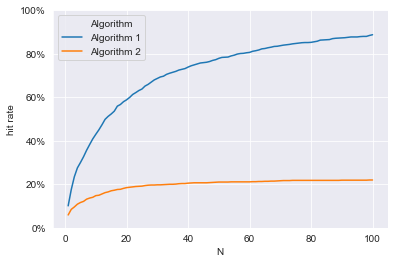

In [68]:
# hit rates plot

ax = sns.lineplot(x='N', y='hit_rate', hue='Algorithm', data=hit_rate_df)
ax.set(xlabel='N', ylabel='hit rate', ylim=(0, 1))
ax.yaxis.set_major_formatter(PercentFormatter(1))

fig = ax.get_figure()
fig.savefig(f"./hit_rates_d-{dim}.png", format='png', dpi=1000)

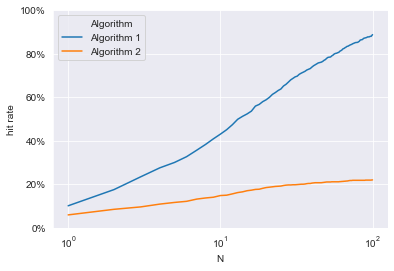

In [69]:
# hit rates plot on log scale

ax = sns.lineplot(x='N', y='hit_rate', hue='Algorithm', data=hit_rate_df)
ax.set(xlabel='N', ylabel='hit rate', ylim=(0, 1), xscale="log")
ax.yaxis.set_major_formatter(PercentFormatter(1))

fig = ax.get_figure()
fig.savefig(f"./hit_rates_d-{dim}_log.png", format='png', dpi=1000)
